In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [68]:
imgs = list(sorted(os.listdir(os.path.join('./', "img"))))
print(imgs)

['Ganglioneuroblastoma_0.jpg', 'Ganglioneuroblastoma_1.jpg', 'Ganglioneuroblastoma_10.jpg', 'Ganglioneuroblastoma_2.jpg', 'Ganglioneuroblastoma_3.jpg', 'Ganglioneuroblastoma_4.jpg', 'Ganglioneuroblastoma_6.jpg', 'Ganglioneuroblastoma_7.jpg', 'Ganglioneuroblastoma_8.jpg', 'Ganglioneuroblastoma_9.jpg', 'Neuroblastoma_0.jpg', 'Neuroblastoma_1.jpg', 'Neuroblastoma_10.jpg', 'Neuroblastoma_11.jpg', 'Neuroblastoma_12.jpg', 'Neuroblastoma_13.jpg', 'Neuroblastoma_14.jpg', 'Neuroblastoma_15.jpg', 'Neuroblastoma_16.jpg', 'Neuroblastoma_17.jpg', 'Neuroblastoma_2.jpg', 'Neuroblastoma_3.jpg', 'Neuroblastoma_4.jpg', 'Neuroblastoma_5.jpg', 'Neuroblastoma_6.jpg', 'Neuroblastoma_7.jpg', 'Neuroblastoma_8.jpg', 'Neuroblastoma_9.jpg', 'normal_0.jpg', 'normal_1.jpg', 'normal_10.jpg', 'normal_11.jpg', 'normal_12.jpg', 'normal_13.jpg', 'normal_14.jpg', 'normal_15.jpg', 'normal_16.jpg', 'normal_17.jpg', 'normal_18.jpg', 'normal_19.jpg', 'normal_2.jpg', 'normal_20.jpg', 'normal_21.jpg', 'normal_22.jpg', 'normal

In [69]:
matching = [s for s in imgs if "Neuro" in s]
print(matching)

['Neuroblastoma_0.jpg', 'Neuroblastoma_1.jpg', 'Neuroblastoma_10.jpg', 'Neuroblastoma_11.jpg', 'Neuroblastoma_12.jpg', 'Neuroblastoma_13.jpg', 'Neuroblastoma_14.jpg', 'Neuroblastoma_15.jpg', 'Neuroblastoma_16.jpg', 'Neuroblastoma_17.jpg', 'Neuroblastoma_2.jpg', 'Neuroblastoma_3.jpg', 'Neuroblastoma_4.jpg', 'Neuroblastoma_5.jpg', 'Neuroblastoma_6.jpg', 'Neuroblastoma_7.jpg', 'Neuroblastoma_8.jpg', 'Neuroblastoma_9.jpg']


In [73]:
matching[0][:-4]

'Neuroblastoma_0.'

In [3]:
def vertical_flip(image):
    return image[::-1, :]

def random_crop(image, mask, crop_size):
    crop_size = check_size(crop_size)
    h, w = image.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    return image, mask


def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size


def augment_one(image, in_mask):
    img_list = []
    in_mask_list = []
    cropped = (int(0.8 * image.shape[0]), int(0.8 * image.shape[1]))

    img_list.append(vertical_flip(image))
    in_mask_list.append(vertical_flip(in_mask))

    i, m = random_crop(image, in_mask, cropped)

    img_list.append(vertical_flip(i))
    in_mask_list.append(vertical_flip(m))

    img_list.append(i)
    in_mask_list.append(m)

    cropped = (int(0.6 * image.shape[0]), int(0.6 * image.shape[1]))
    i, m = random_crop(image, in_mask, cropped)
    
    img_list.append(i)
    in_mask_list.append(m)

    cropped = (int(0.4 * image.shape[0]), int(0.4 * image.shape[1]))
    i, m = random_crop(image, in_mask, cropped)
    
    img_list.append(i)
    in_mask_list.append(m)
    return img_list, in_mask_list

In [80]:
for name in matching:
    img = Image.open(f'./img/{name[:-4]}.jpg')
    mask = Image.open(f'./groundtruth/{name[:-4]}.tif')
    mask = np.array(mask)
    img = np.array(img)

    imgs, masks = augment_one(img, mask)

    for i in range(len(imgs)):
        Image.fromarray(imgs[i]).save(f'./augmented/img/{name[:-4]}_a_{i}.jpg')
        Image.fromarray(masks[i]).save(f'./augmented/groundtruth/{name[:-4]}_a_{i}.tif')
    

## -----------------------------

In [5]:
name = 'Neuroblastoma_1.jpg'

img = Image.open(f'./img/{name[:-4]}.jpg')
mask = Image.open(f'./groundtruth/{name[:-4]}.tif')
mask = np.array(mask)
img = np.array(img)

imgs, masks = augment_one(img, mask)

for i in range(len(imgs)):
    Image.fromarray(imgs[i]).save(f'./augmented/img/{name[:-4]}_a_{i}.jpg')
    Image.fromarray(masks[i]).save(
        f'./augmented/groundtruth/{name[:-4]}_a_{i}.tif')


In [188]:
imgs = list(sorted(os.listdir(os.path.join('./', "groundtruth"))))
matching = [s for s in imgs if "Neuro" in s]
print(len(matching))

98


In [189]:
import torch

for name in matching:
    mask = Image.open(f'./img/{name[:-4]}.jpg')
    mask = np.array(mask)
    
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        if (ymin >= ymax) or (xmin >= xmax):
            print(name)
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)    

Neuroblastoma_0.tif
Neuroblastoma_0.tif
Neuroblastoma_0.tif
Neuroblastoma_0.tif
Neuroblastoma_0_a_0.tif
Neuroblastoma_0_a_0.tif
Neuroblastoma_0_a_0.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_1.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_2.tif
Neuroblastoma_0_a_4.tif
Neuroblastoma_1.tif
Neuroblastoma_10_a_0.tif
Neuroblastoma_10_a_1.tif
Neuroblastoma_10_a_3.tif
Neuroblastoma_10_a_3.tif
Neuroblastoma_10_a_4.tif
Neuroblastoma_10_a_4.tif
Neuroblastoma_11.tif
Neuroblastoma_11_a_0.tif
Neuroblastoma_11_a_2.tif
Neuroblastoma_11_a_2.tif
Neuroblastoma_11_a_2.tif
Neuroblastoma_11_a_3.tif
Neuroblastoma_11_a_3.tif


KeyboardInterrupt: 

In [174]:
print(boxes.shape)
print(boxes)

torch.Size([8, 4])
tensor([[300., 174., 410., 263.],
        [363.,  88., 471., 180.],
        [360.,   0., 511.,  87.],
        [224., 130., 320., 238.],
        [  0.,   0.,   6.,  17.],
        [167.,   0., 264.,  31.],
        [  0., 301.,   4., 351.],
        [468.,  77., 511., 181.]])


In [106]:
boxes

tensor([[1.2600e+03, 3.3000e+02, 1.2790e+03, 3.8700e+02],
        [1.6000e+02, 1.0700e+02, 2.7500e+02, 2.1800e+02],
        [1.0700e+03, 2.9800e+02, 1.1630e+03, 4.1000e+02],
        [1.7300e+02, 8.6400e+02, 2.8600e+02, 9.6600e+02],
        [3.3900e+02, 4.9700e+02, 4.4100e+02, 5.9500e+02],
        [9.9800e+02, 8.5400e+02, 1.0980e+03, 9.5400e+02],
        [1.0200e+03, 6.1500e+02, 1.1300e+03, 7.0400e+02],
        [5.9900e+02, 8.8900e+02, 7.0000e+02, 9.9200e+02],
        [0.0000e+00, 2.2800e+02, 3.5000e+01, 3.2400e+02],
        [4.9300e+02, 5.6500e+02, 5.9200e+02, 6.4200e+02],
        [5.3700e+02, 3.6000e+01, 6.3100e+02, 1.3100e+02],
        [6.3000e+01, 7.0900e+02, 1.5300e+02, 8.1500e+02],
        [8.7900e+02, 2.5300e+02, 9.8200e+02, 3.3000e+02],
        [8.2300e+02, 7.6000e+01, 9.2000e+02, 1.8900e+02],
        [4.8100e+02, 7.4700e+02, 5.9500e+02, 8.4900e+02],
        [2.0100e+02, 5.4100e+02, 3.0900e+02, 6.2400e+02],
        [6.0800e+02, 1.7700e+02, 7.1600e+02, 3.1700e+02],
        [9.820

In [161]:
mask1 = Image.open(f'./groundtruth/Neuroblastoma_0_a_1.tif')
mask2 = Image.open(f'./groundtruth/Neuroblastoma_0.tif')

In [164]:
mask = np.array(mask1)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

pos = np.where(masks[3])
xmin = np.min(pos[1])
xmax = np.max(pos[1])
ymin = np.min(pos[0])
ymax = np.max(pos[0])
xmin, ymin, xmax, ymax
boxes.append([xmin, ymin, xmax, ymax])
boxes = torch.as_tensor(boxes, dtype=torch.float32)    
boxes

tensor([[ 339.,  774.,  411.,  818.],
        [ 718.,  180.,  807.,  288.],
        [ 224.,  369.,  339.,  529.],
        [ 583.,  270.,  648.,  363.],
        [ 681.,  436.,  825.,  566.],
        [ 831.,   54.,  935.,  143.],
        [ 363.,  354.,  443.,  441.],
        [ 618.,  649.,  719.,  796.],
        [ 872.,    0.,  968.,   71.],
        [ 892.,   98., 1006.,  221.],
        [ 791.,  348.,  884.,  455.],
        [ 816.,  279.,  921.,  380.],
        [ 749.,  621.,  885.,  733.],
        [ 898.,  263.,  998.,  360.],
        [1019.,  132., 1023.,  148.],
        [ 259.,    0.,  422.,   96.],
        [ 151.,  504.,  255.,  564.],
        [ 996.,  260., 1023.,  347.],
        [ 359.,  487.,  436.,  564.],
        [ 545.,    0.,  616.,   91.],
        [ 974.,  587., 1023.,  649.],
        [ 907.,  590., 1012.,  696.],
        [ 981.,  152., 1023.,  256.],
        [ 583.,  270.,  648.,  363.]])

In [ ]:
[xmin, ymin, xmax, ymax

[ 339.,  774.,  411.,  818.],
        [ 718.,  180.,  807.,  288.],
        [ 224.,  369.,  339.,  529.],
        [ 583.,  270.,  648.,  363.],

[ 441.,    0.,  519.,   83.],
        [ 820.,  569.,  909.,  677.],
        [ 590.,    0.,  667.,   33.],
        [1065.,  858., 1217., 1000.],
        [ 326.,  328.,  441.,  488.],

In [66]:
for i in range(len(imgs)):
    Image.fromarray(imgs[i]).save(f'./augmented/img/image_{i}.jpg')
    Image.fromarray(masks[i]).save(f'./augmented/groundtruth/mask_{i}.tif')

0


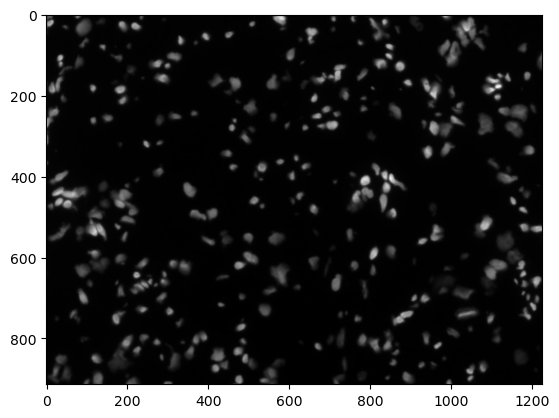

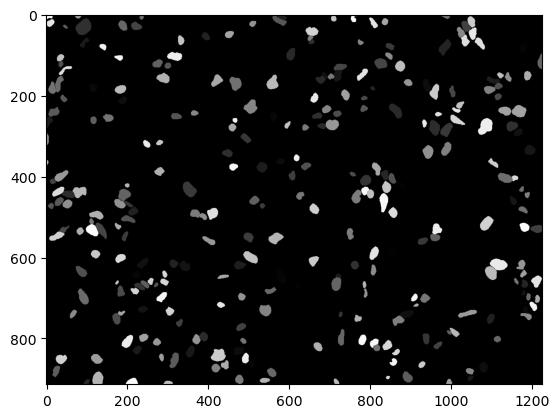

1


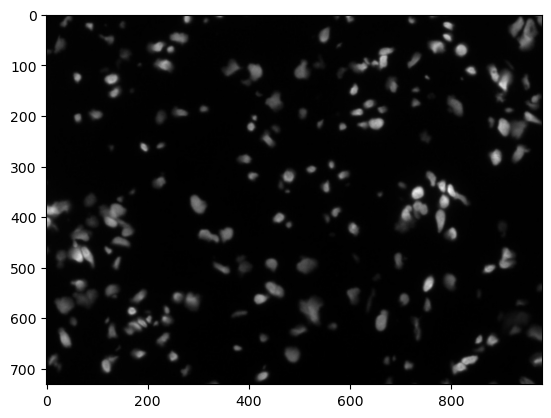

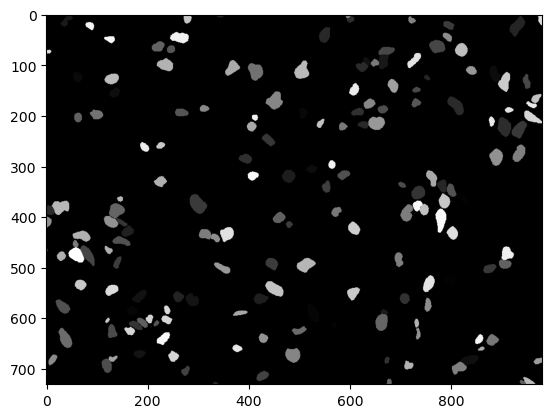

2


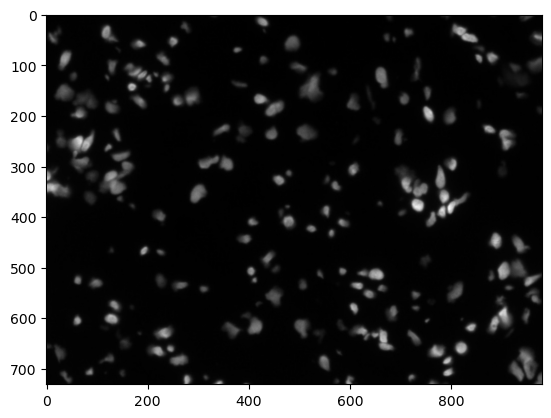

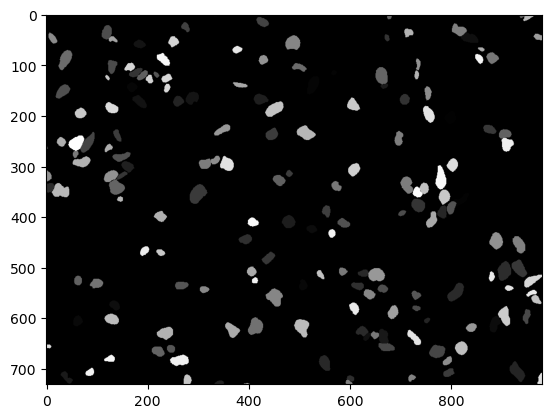

3


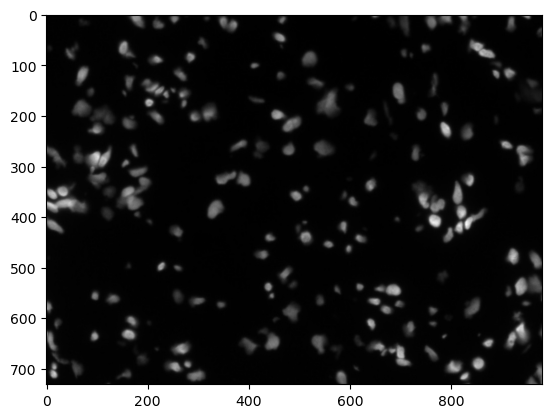

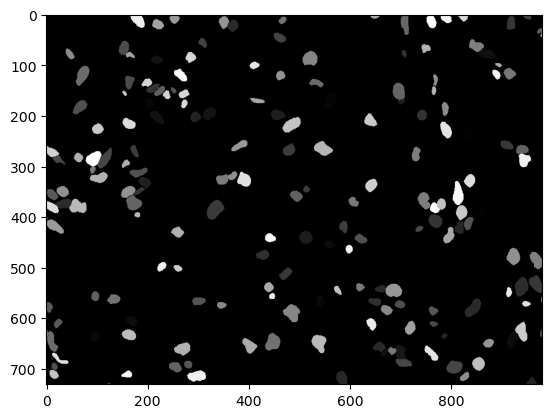

In [65]:
for i in range(len(imgs)):
    print(i)
    plt.imshow(imgs[i], cmap='gray')
    plt.show()
    plt.imshow(masks[i], cmap='gray')
    plt.show()

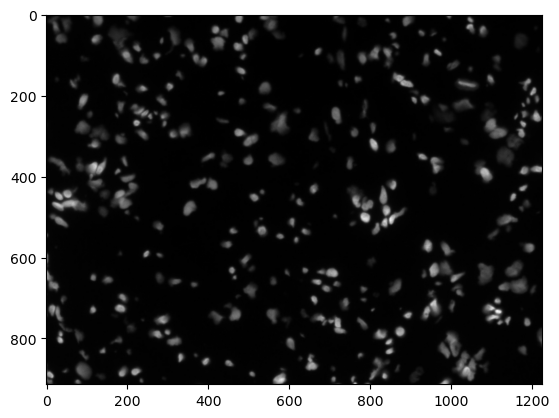

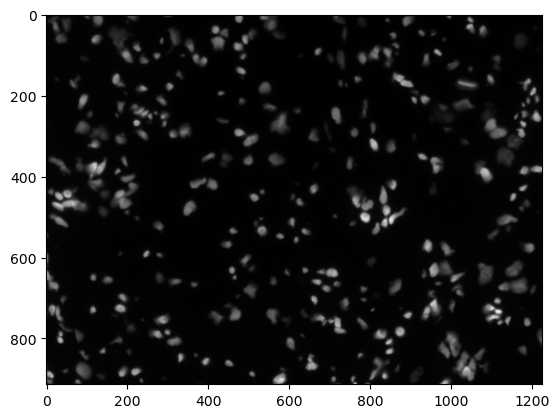

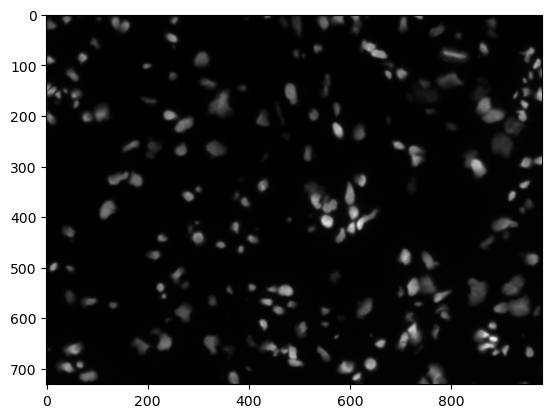

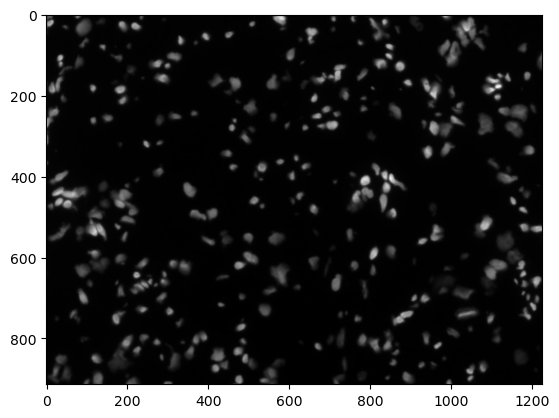

In [50]:
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(gaussian_noise(img), cmap='gray')
plt.show()
img[0]
plt.imshow(random_crop(img,( int(0.8 * img.shape[0]), int(0.8 * img.shape[1]))), cmap='gray')
plt.show()
plt.imshow(vertical_flip(img), cmap='gray')
plt.show()

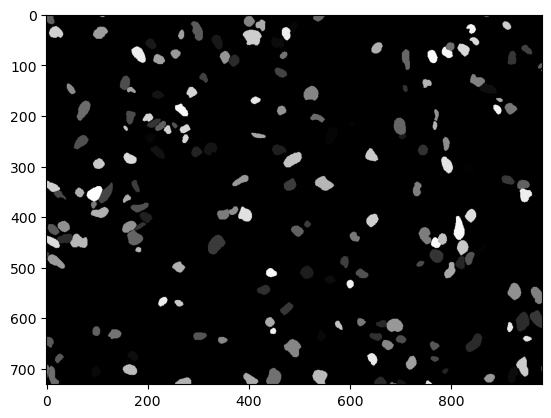

In [51]:
plt.imshow(random_crop(mask,( int(0.8 * mask.shape[0]), int(0.8 * mask.shape[1]))), cmap='gray')
plt.show()

In [53]:
crp = random_crop(mask,( int(0.8 * mask.shape[0]), int(0.8 * mask.shape[1])))

In [54]:
m = Image.fromarray(crp)
m.save('crp.tif')

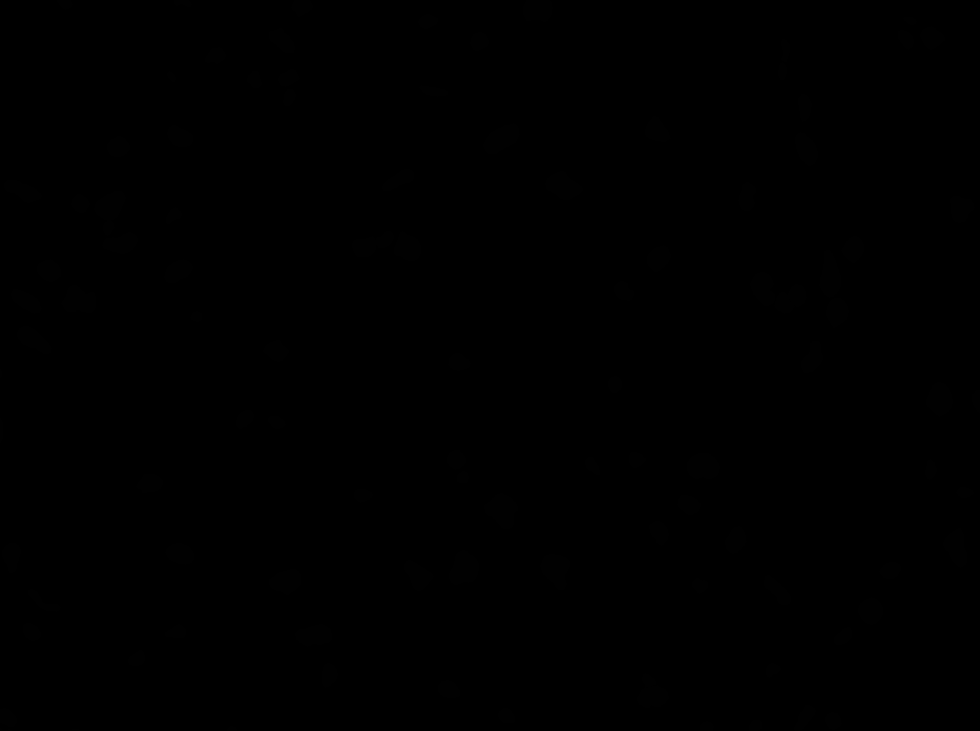

In [55]:
Image.open('crp.tif')

In [56]:
mask = Image.open('crp.tif')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask = np.array(mask)

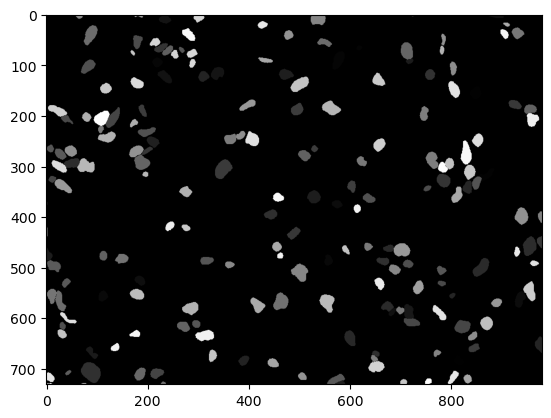

In [57]:
plt.imshow(mask, cmap='gray')
plt.show()